# Yelp Academic Dataset

## Business Understanding

Yelp combined the Yellow Pages with customer reviews. They really changed the way people found and selected businesses. This is particulary true for restaurants.

Questions
- Are there differences in the stars ratings by major categories (Restaurants, Shopping, Nightlife, ...)? Any differences in Restaurant categories?
- What affects if a business will close?
- Does vicinity to other similar business help or hurt ratings?

Understanding the average ratings for business categories or specifically restaurant categores can help someone decide if they really do want to open a restaurant and if so what kind. Or if they already have a type of restaurant in mind, help them see how it would typically fare.

One of the variables provided by the dataset is "is_open". Being able to predict if a business will stay open is a very important piece of information and finding out what factors affect this will also be helpful.

Businesses, and in particular Restaurants, seem to cluster together. A quick search of the internet indicates that this is an industry accepted good practice. It would be interesting to see if the data supports this.

This analysis focuses on the data from the business.json file. Sentiment analysis of the reviews and classification of the images would be also very interesting to examine.

In [1]:
import pandas as pd
import ast
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
business_df = pd.read_json('yelp_dataset/yelp_academic_dataset_business.json', lines=True)

## Data Understanding

In [3]:
business_df.shape

(188593, 15)

In [4]:
business_df.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,neighborhood,postal_code,review_count,stars,state
0,1314 44 Avenue NE,"{'BikeParking': 'False', 'BusinessAcceptsCredi...",Apn5Q_b6Nz61Tq4XzPdf9A,"Tours, Breweries, Pizza, Restaurants, Food, Ho...",Calgary,"{'Monday': '8:30-17:0', 'Tuesday': '11:0-21:0'...",1,51.091813,-114.031675,Minhas Micro Brewery,,T2E 6L6,24,4.0,AB
1,,"{'Alcohol': 'none', 'BikeParking': 'False', 'B...",AjEbIBw6ZFfln7ePHha9PA,"Chicken Wings, Burgers, Caterers, Street Vendo...",Henderson,"{'Friday': '17:0-23:0', 'Saturday': '17:0-23:0...",0,35.960734,-114.939821,CK'S BBQ & Catering,,89002,3,4.5,NV
2,1335 rue Beaubien E,"{'Alcohol': 'beer_and_wine', 'Ambience': '{'ro...",O8S5hYJ1SMc8fA4QBtVujA,"Breakfast & Brunch, Restaurants, French, Sandw...",MontrÃ©al,"{'Monday': '10:0-22:0', 'Tuesday': '10:0-22:0'...",0,45.540503,-73.599300,La Bastringue,Rosemont-La Petite-Patrie,H2G 1K7,5,4.0,QC
3,211 W Monroe St,None,bFzdJJ3wp3PZssNEsyU23g,"Insurance, Financial Services",Phoenix,None,1,33.449999,-112.076979,Geico Insurance,,85003,8,1.5,AZ
4,2005 Alyth Place SE,{'BusinessAcceptsCreditCards': 'True'},8USyCYqpScwiNEb58Bt6CA,"Home & Garden, Nurseries & Gardening, Shopping...",Calgary,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",1,51.035591,-114.027366,Action Engine,,T2H 0N5,4,2.0,AB


We can see that data manipulation will need to be done on the attributes and categories columns. Also, from the hours column, it may be useful extract total hours open and which days of the the week the business is open.

In [5]:
business_df.describe()

,is_open,latitude,longitude,review_count,stars
count,188593.000000,188587.000000,188587.000000,188593.000000,188593.000000
mean,0.830391,38.506793,-97.490873,31.797310,3.631550
std,0.375290,5.122684,17.693360,104.124212,1.016783
min,0.000000,-71.753941,-180.000000,3.000000,1.000000
25%,1.000000,33.630878,-112.279276,4.000000,3.000000
50%,1.000000,36.143595,-111.777460,9.000000,3.500000
75%,1.000000,43.593106,-79.982958,24.000000,4.500000
max,1.000000,85.051129,115.086769,7968.000000,5.000000


Using describe, we see that there are 188593 observations. Since describe only returns quantatative variables we can also see which variables are such. The average number of stars for all businesses is 3.63 with a standard deviation of about 1.0.

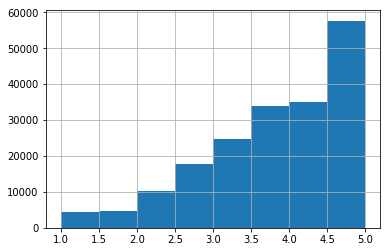

In [6]:
business_df.stars.hist(bins=8)

In [7]:
business_df.groupby(by=['is_open']).stars.mean()

is_open
0    3.514756
1    3.655406
Name: stars, dtype: float64

In [8]:
business_df.isnull().mean()

address         0.000000
attributes      0.136728
business_id     0.000000
categories      0.002869
city            0.000000
hours           0.237559
is_open         0.000000
latitude        0.000032
longitude       0.000032
name            0.000000
neighborhood    0.000000
postal_code     0.000000
review_count    0.000000
stars           0.000000
state           0.000000
dtype: float64

Checking for missing values, we see that except for hours and attributes, the data has almost no missing values. 24% of the hours column has missing values. 14% for attributes and less than 1% for categories.

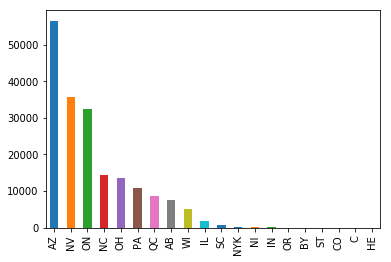

In [9]:
business_df.state.value_counts()[:20].plot.bar()

## Data Preparation

### Attributes Column

In [10]:
# Flattens a dictionary where certain values are string representations
#   of a dictionary
def flatten_dict(d):
    new_dict = {}
    for k, v in d.items():
        if v[0] == '{': #handle dictionary string
            nested_dict = ast.literal_eval(v)
            for k1, v1 in nested_dict.items():
                new_dict['_'.join([k,k1])] = v1
        else:
            new_dict[k] = v
    return new_dict

# Takes a Panda Series of sparse dictionaries and returns a dataframe 
#   with new columns for each key that exists
def flatten_series(s):
    new_columns = []
    for i, v in s.iteritems():
        if v is None:
            new_columns.append({})
        else:
            new_columns.append(flatten_dict(v))
        
    new_df = pd.DataFrame(new_columns)    
    return new_df


In [11]:
# Fix attributes column
attributes_df = flatten_series(business_df.attributes)

# Fix booleans
attributes_df.replace({'True': True, 'False': False}, inplace=True)

# Fill missing values with False
attributes_df.fillna(False, inplace=True)

business_df = pd.concat([business_df, attributes_df], axis='columns')

### Categories

In [12]:
test_df = business_df.categories[:1000].str.get_dummies(sep=', ')
test_df.columns

Index(['ATV Rentals/Tours', 'Accessories', 'Accountants', 'Active Life',
       'Acupuncture', 'Adult', 'Advertising', 'Air Duct Cleaning',
       'Airport Lounges', 'Airports',
       ...
       'Weight Loss Centers', 'Wheel & Rim Repair', 'Wholesale Stores', 'Wigs',
       'Wildlife Control', 'Windshield Installation & Repair',
       'Wine & Spirits', 'Wine Bars', 'Women's Clothing', 'Yoga'],
      dtype='object', length=555)

The get_dummies function is can create dummy variables from a string with separators. Running it just the first 1000 rows of categories results in 555 new columns. Running it on the entire dataset of 188593 rows would take very long and result in much too many new columns that are very sparse.

Instead, we can write a custom function that extracts just the categories of interest.

In [13]:
# Create a dummy variables from a series with multiple values in each element
def get_categories(s, subset):
    df = pd.DataFrame()
    for category in subset:
        df[category] = s.str.contains(category)
    return df

### Handle Missing Values

In [14]:
main_cats = ['Restaurants', 'Shopping', 'Nightlife', 'Active Life', 'Beauty & Spas', 'Automotive', 'Home Services']
cat_df = get_categories(business_df.categories, main_cats)

# Fill missing values with False
cat_df.fillna(False, inplace=True)

business_df = pd.concat([business_df, cat_df], axis='columns')

print(cat_df.head())

   Restaurants  Shopping  Nightlife  Active Life  Beauty & Spas  Automotive  \
0         True     False      False        False          False       False   
1         True     False      False        False          False       False   
2         True     False      False        False          False       False   
3        False     False      False        False          False       False   
4        False      True      False        False          False        True   

   Home Services  
0          False  
1          False  
2          False  
3          False  
4          False  


For the attributes column, it would be safe to assume that if the value is unknown that it's false. The same goes for the business categories. This was done before the new columns were concatenated to the main dataframe.